<a href="https://colab.research.google.com/github/neel26desai/cmpe297_timegpt_tabula_gnn/blob/main/FienTuning_TimeGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

Finetuning time gpt based on airline travel passegner data, using

1. Finetune Step

2. Finetune depth

In [1]:
!pip install nixtla
!pip install datasetsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 8.8 MB/s eta 0:00:00


In [3]:
from google.colab import userdata

In [4]:
import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
#setting up client
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = userdata.get('nixta_apikey')
)

## Loading Data

In [23]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.head()

,timestamp,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  144 non-null    object
 1   value      144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [25]:
df.describe()

,value
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [9]:
df.shape

(144, 2)

inetune_steps=10 means the model will go through 10 iterations of training data

In [26]:
#prediction horizon of 12
timegpt_fcst_finetune_df = nixtla_client.forecast(
    df=df, h=12, finetune_steps=10,
    time_col='timestamp', target_col='value',
)

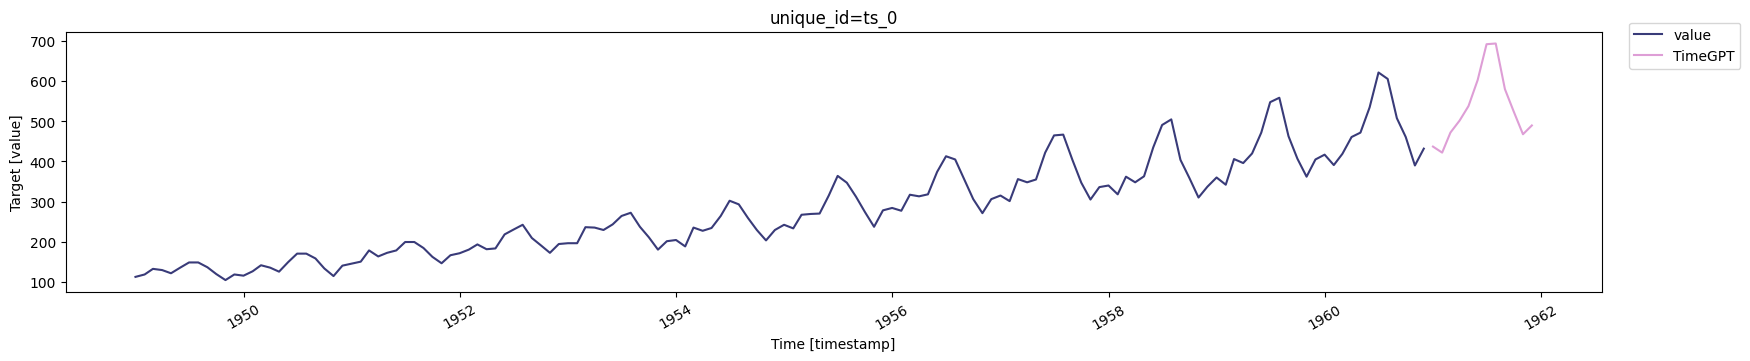

In [27]:
nixtla_client.plot(
    df, timegpt_fcst_finetune_df,
    time_col='timestamp', target_col='value',
)

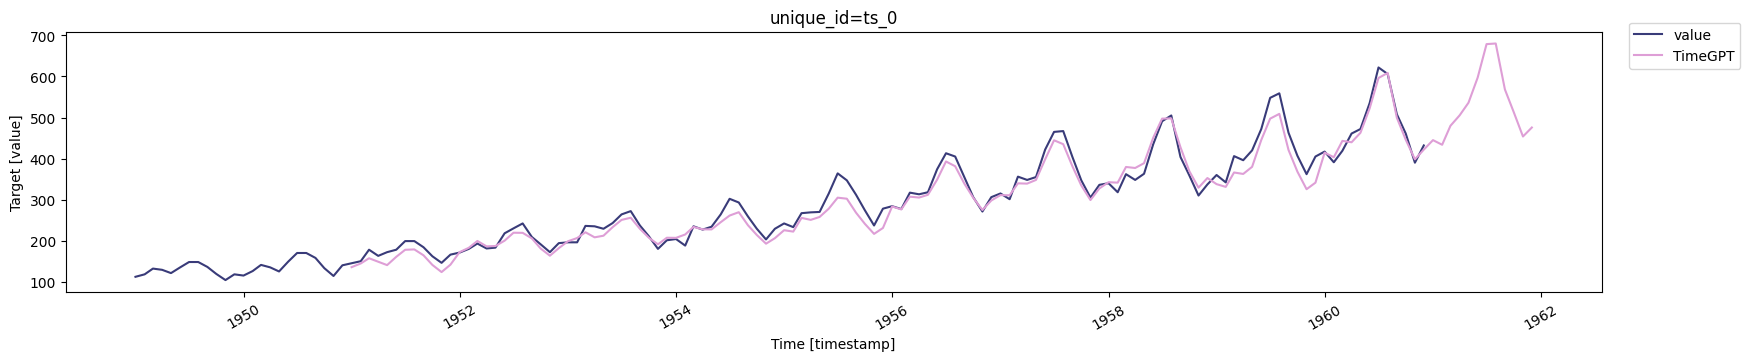

In [32]:
#prediction horizon of 12
timegpt_fcst_finetune_df = nixtla_client.forecast(
    df=df, h=12, finetune_steps=5,
    time_col='timestamp', target_col='value', add_history=True,
)

nixtla_client.plot(
    df, timegpt_fcst_finetune_df,
    time_col='timestamp', target_col='value',
)

### Adajusting finetuning depth

finetune_depth takes values among [1, 2, 3, 4, 5]. By default, it is set to 1, which means that a small set of the model’s parameters are being adjusted, whereas a value of 5 fine-tunes the maximum amount of parameters.

In [28]:
train = df[:-24]
test = df[-24:]

In [29]:
depths = [1, 2, 3, 4, 5]

test = test.copy()

for depth in depths:
    preds_df = nixtla_client.forecast(
    df=train,
    h=24,
    finetune_steps=5,
    finetune_depth=depth,
    time_col='timestamp',
    target_col='value')

    preds = preds_df['TimeGPT'].values

    test.loc[:,f'TimeGPT_depth{depth}'] = preds

In [30]:
test['unique_id'] = 0

evaluation = evaluate(test, metrics=[mae, mse], time_col="timestamp", target_col="value")
evaluation

,unique_id,metric,TimeGPT_depth1,TimeGPT_depth2,TimeGPT_depth3,TimeGPT_depth4,TimeGPT_depth5
0,0,mae,22.675540,17.908963,21.243560,24.745096,29.183245
1,0,mse,677.254283,461.320852,671.131971,991.835359,1147.905234
